In [1]:
import os
import math
import random
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd
from pandas import datetime
from pandas import DataFrame
import matplotlib.pyplot as plt
from pandas import Series

from sklearn.model_selection import train_test_split
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from statsmodels.stats.stattools import durbin_watson

from statsmodels.tsa.vector_ar.vecm import coint_johansen

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

C:\ProgramData\Anaconda3\envs\Forecatsing\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [2]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [3]:
# dataset indonesia (jakarta)
case = pd.read_csv('data/new/case_maret_july.csv')
mobility = pd.read_csv('data/new/mobility_maret_july.csv')
weather = pd.read_csv('data/new/weather_maret_july.csv')
case.set_index('date', inplace=True)
#weather.set_index('date', inplace=True)
mobility.set_index('date', inplace=True)

In [4]:
new_weather = weather.interpolate(method='spline', order=2)
new_weather.head()

new_weather.set_index('date', inplace=True)

In [5]:
data = pd.concat([case, new_weather, mobility], axis=1)
data.head()

,case,rh,avt,mxt,mnt,retail_recreation,grocery_pahrmacy,parks,transit_station,workplace,residential
date,,,,,,,,,,,
2020-03-18,38,86.0,27.6,29.0,25.800000,-22,-3,-28,-32,-19,11
2020-03-19,50,83.0,28.1,31.4,25.800000,-28,-12,-33,-38,-21,12
2020-03-20,14,82.0,27.4,31.2,25.200000,-30,-11,-32,-42,-23,15
2020-03-21,44,81.0,28.1,32.4,26.521978,-35,-5,-38,-40,-10,11
2020-03-22,36,84.0,27.2,31.2,25.000000,-49,-22,-59,-49,-12,14


In [6]:
data.shape

(423, 11)

In [7]:
train = data[:413]
test = data[413:]

In [8]:
cointegration_test(train)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
case   ::  393.84    > 263.2603  =>   True
rh     ::  300.44    > 219.4051  =>   True
avt    ::  212.61    > 179.5199  =>   True
mxt    ::  153.6     > 143.6691  =>   True
mnt    ::  99.23     > 111.7797  =>   False
retail_recreation ::  59.7      > 83.9383   =>   False
grocery_pahrmacy ::  38.11     > 60.0627   =>   False
parks  ::  18.1      > 40.1749   =>   False
transit_station ::  7.87      > 24.2761   =>   False
workplace ::  3.84      > 12.3212   =>   False
residential ::  0.11      > 4.1296    =>   False


In [9]:
model = VAR(train)
lag_orders = model.select_order(15)
lag_orders.summary()

C:\ProgramData\Anaconda3\envs\Forecatsing\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


,AIC,BIC,FPE,HQIC
0,34.23,34.34,7.317e+14,34.27
1,25.05,26.38*,7.603e+10,25.58
2,24.50,27.03,4.358e+10,25.50*
3,24.19,27.94,3.221e+10,25.67
4,24.18,29.14,3.221e+10,26.15
5,24.10,30.27,2.975e+10,26.54
6,23.95,31.33,2.612e+10,26.87
7,23.29,31.88,1.376e+10,26.69
8,23.22*,33.03,1.324e+10*,27.11
9,23.48,34.49,1.769e+10,27.84


In [10]:
lag_order = 7
results = model.fit(lag_order, ic="aic")
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 24, Aug, 2021
Time:                     11:36:59
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                    31.7851
Nobs:                     406.000    HQIC:                   26.6694
Log likelihood:          -10212.6    FPE:                1.41310e+10
AIC:                      23.3185    Det(Omega_mle):     2.04485e+09
--------------------------------------------------------------------
Results for equation case
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                     2724.555701      1676.705197            1.625           0.104
L1.case                      0.460771         0.054413            8.468           0.000
L1.rh                       -7.49

In [11]:
out = durbin_watson(results.resid)

for col, val in zip(data.columns, out):
    print((col), ':', round(val, 2))

case : 2.04
rh : 1.97
avt : 1.98
mxt : 1.97
mnt : 2.02
retail_recreation : 1.95
grocery_pahrmacy : 2.0
parks : 1.97
transit_station : 1.98
workplace : 1.99
residential : 1.88


In [12]:
fc = results.forecast(train.values[-lag_order:], steps=10)
fc = pd.DataFrame(fc, columns=["case", "rh", "avt", "mxt", "mnt", "retail_recreation","grocery_pahrmacy","parks","transit_station","workplace","residential"])
fc

,case,rh,avt,mxt,mnt,retail_recreation,grocery_pahrmacy,parks,transit_station,workplace,residential
0,882.638806,74.100223,29.105249,32.926629,26.424191,-12.067309,12.523865,-43.818952,-21.301471,-24.232873,6.660217
1,956.622499,75.094012,28.965555,32.800649,26.244582,-16.394022,8.493231,-41.600389,-26.451147,-31.726710,7.657493
2,849.304092,76.421749,29.195313,33.459477,26.235770,-15.848594,4.865601,-35.954046,-32.980501,-40.823071,12.964822
3,798.674819,76.328426,28.497946,32.247212,26.242755,-17.618041,7.869982,-43.196397,-22.525785,-23.779976,5.979288
4,771.932328,74.357023,28.803303,32.618674,25.657773,-20.952746,1.267342,-48.702994,-24.452169,-19.190158,6.556207
5,749.109124,74.745405,28.957967,33.158609,25.904648,-18.523571,3.529757,-42.729538,-29.912948,-33.954557,9.949708
6,663.144218,75.316654,28.685376,32.451773,26.002145,-22.058383,-0.899359,-46.200495,-30.354546,-29.214148,10.066497
7,842.157888,75.316810,28.510442,32.513161,25.772888,-19.201294,0.567554,-46.699940,-28.492258,-27.379883,9.204208
8,886.215739,75.365929,28.563652,32.587054,25.803875,-20.799556,-0.351063,-46.572660,-28.171422,-26.557721,8.387154
9,934.452547,75.504134,28.651386,32.528335,25.876783,-18.044923,0.221998,-40.447319,-32.965135,-36.850260,12.969674


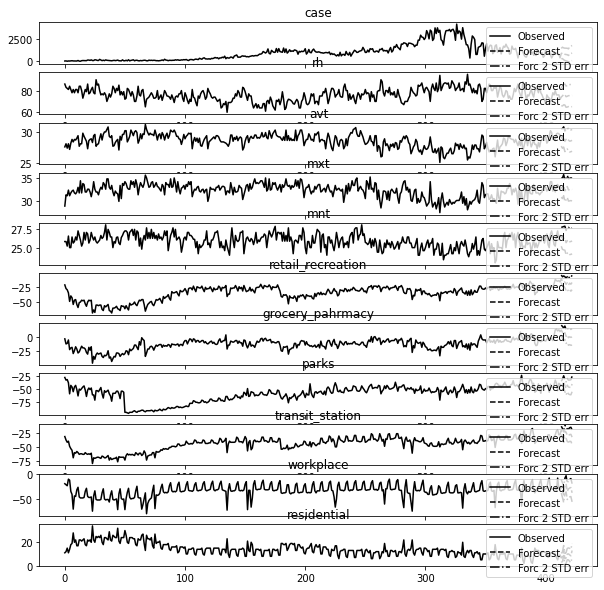

In [13]:
results.plot_forecast(10);

In [14]:
list_eval = test['case'].tolist()
list_hasil = fc['case'].tolist()
mse = mean_squared_error(list_eval, list_hasil)
mse

21983.44307779292

In [15]:
rmse = mean_squared_error(list_eval, list_hasil, squared=False)
rmse

148.26814586347575

In [16]:
mae = mean_absolute_error(list_eval, list_hasil)
mae

116.13874037595625